# ***In this file, we will be experimenting various optimisation techniques on BERT+LSTM model.***

# STEP 1: Data Preprocessing
(Remove irrelevant columns, Expand text cleaning, Check & handle for class imbalance using Random Oversampling)

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertModel, BertConfig
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Step 1: Load and Clean the Dataset
df = pd.read_csv('labeled_data.csv')

# Display basic information about the dataset
print("Initial Dataset Information:")
print(df.info())
print(df.head())

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'count']  # Drop these columns as they are irrelevant
df = df.drop(columns=columns_to_drop, errors='ignore')

# Map the labels to a single 'class' column for consistency
df['class'] = df['class'].map({0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'})

# Check for null values
print("\nChecking for null values...")
print(df.isnull().sum())

# Fill or drop missing values (if any)
df.dropna(subset=['tweet', 'class'], inplace=True)

# Display class distribution
print("\nClass Distribution:")
print(df['class'].value_counts())

# Function for text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Display cleaned data
print("\nCleaned Tweets (sample):")
print(df[['tweet', 'clean_tweet']].sample(5))

# Save cleaned data (optional)
df.to_csv('cleaned_data.csv', index=False)

# Split the data into training, validation, and test sets
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

# Handle class imbalance using Random Oversampling
oversampler = RandomOverSampler(random_state=1508)
train_resampled, train_labels_resampled = oversampler.fit_resample(
    train[['clean_tweet']],
    train['class']
)

# Display class distribution after oversampling
print("\nClass Distribution After Oversampling:")
print(pd.Series(train_labels_resampled).value_counts())

# Tokenization
print('Loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encode and prepare for BERT
def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for sentence in data:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 64

train_inputs, train_masks = bert_encode(train_resampled['clean_tweet'], MAX_LEN)
train_labels = pd.factorize(train_labels_resampled)[0]  # Convert labels to numeric

validation_inputs, validation_masks = bert_encode(validation['clean_tweet'], MAX_LEN)
validation_labels = pd.factorize(validation['class'])[0]

train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
validation_labels = torch.tensor(validation_labels)

# Dataloader preparation
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Define flat_accuracy function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define BERT + LSTM Model
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_labels=3, hidden_dim=256):
        super(BertLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state
        lstm_output, (h_n, _) = self.lstm(last_hidden_state)
        logits = self.classifier(h_n[-1])
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertLSTMClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
scaler = GradScaler()

# Training loop
for epoch_i in range(epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        with autocast():
            logits = model(b_input_ids, attention_mask=b_input_mask)
            loss = nn.CrossEntropyLoss()(logits, b_labels)

        total_loss += loss.item()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch_i+1}/{epochs}, Loss: {avg_train_loss:.2f}")

# Validation loop
model.eval()
eval_accuracy = 0

for batch in validation_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        logits = model(b_input_ids, attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    eval_accuracy += flat_accuracy(logits, label_ids)

print("Validation Accuracy:", eval_accuracy / len(validation_dataloader))


Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4          

<ipython-input-3-d9631a8f3f4e>:154: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-3-d9631a8f3f4e>:168: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4, Loss: 0.52
Epoch 2/4, Loss: 0.26
Epoch 3/4, Loss: 0.20
Epoch 4/4, Loss: 0.15
Validation Accuracy: 0.8660790598290597


# STEP 2: FEATURE ENGINEERING
Incorporate metadata: Added features like tweet_length, num_hashtags, num_mentions, and num_punctuations as additional numerical features concatenated with BERT embeddings,to enhance the model columns

Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4          

<ipython-input-4-db77817967cb>:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-4-db77817967cb>:204: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4, Training Loss: 0.53, Training Accuracy: 0.7888
Epoch 1/4, Validation Loss: 0.39, Validation Accuracy: 0.8532
Epoch 2/4, Training Loss: 0.27, Training Accuracy: 0.9145
Epoch 2/4, Validation Loss: 0.39, Validation Accuracy: 0.8693
Epoch 3/4, Training Loss: 0.19, Training Accuracy: 0.9434
Epoch 3/4, Validation Loss: 0.45, Validation Accuracy: 0.8665
Epoch 4/4, Training Loss: 0.15, Training Accuracy: 0.9583
Epoch 4/4, Validation Loss: 0.45, Validation Accuracy: 0.8786

Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1902
           1       0.87      0.90      0.89       435
           2       0.33      0.58      0.42       142

    accuracy                           0.88      2479
   macro avg       0.72      0.79      0.74      2479
weighted avg       0.91      0.88      0.89      2479



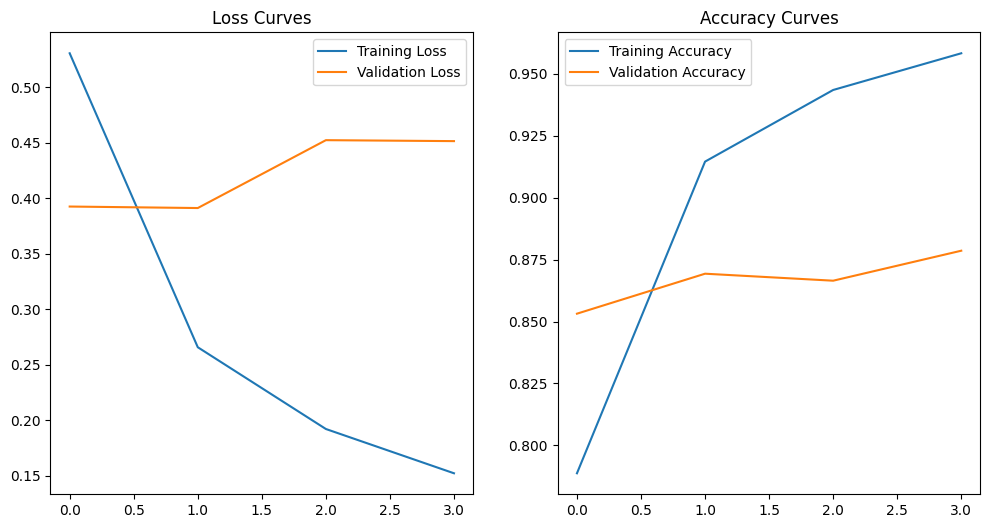

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertModel, BertConfig
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Load and Clean the Dataset
df = pd.read_csv('labeled_data.csv')

# Display basic information about the dataset
print("Initial Dataset Information:")
print(df.info())
print(df.head())

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'count']  # Drop these columns if they are irrelevant
df = df.drop(columns=columns_to_drop, errors='ignore')

# Map the labels to a single 'class' column for consistency
df['class'] = df['class'].map({0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'})

# Check for null values
print("\nChecking for null values...")
print(df.isnull().sum())

# Fill or drop missing values (if any)
df.dropna(subset=['tweet', 'class'], inplace=True)

# Display class distribution
print("\nClass Distribution:")
print(df['class'].value_counts())

# Function for text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Display cleaned data
print("\nCleaned Tweets (sample):")
print(df[['tweet', 'clean_tweet']].sample(5))

# Save cleaned data (optional)
df.to_csv('cleaned_data.csv', index=False)

# Split the data into training, validation, and test sets
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

# Handle class imbalance using Random Oversampling
oversampler = RandomOverSampler(random_state=1508)
train_resampled, train_labels_resampled = oversampler.fit_resample(
    train[['clean_tweet']],
    train['class']
)

# Display class distribution after oversampling
print("\nClass Distribution After Oversampling:")
print(pd.Series(train_labels_resampled).value_counts())

# Feature Engineering: Add additional features
def add_features(df):
    df['tweet_length'] = df['clean_tweet'].apply(len)
    df['num_hashtags'] = df['clean_tweet'].apply(lambda x: x.count('#'))
    df['num_mentions'] = df['clean_tweet'].apply(lambda x: x.count('@'))
    df['num_punctuations'] = df['clean_tweet'].apply(lambda x: sum([1 for char in x if char in '.,!?;:']))
    return df

train_resampled = add_features(train_resampled)
validation = add_features(validation)

# Normalize the engineered features
scaler = StandardScaler()
engineered_features = ['tweet_length', 'num_hashtags', 'num_mentions', 'num_punctuations']

# Normalize training features
train_features = scaler.fit_transform(train_resampled[engineered_features])
train_features = torch.tensor(train_features, dtype=torch.float32)

# Normalize validation features
validation_features = scaler.transform(validation[engineered_features])
validation_features = torch.tensor(validation_features, dtype=torch.float32)

# Tokenization
print('Loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encode and prepare for BERT
def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for sentence in data:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 64

train_inputs, train_masks = bert_encode(train_resampled['clean_tweet'], MAX_LEN)
train_labels = pd.factorize(train_labels_resampled)[0]  # Convert labels to numeric

validation_inputs, validation_masks = bert_encode(validation['clean_tweet'], MAX_LEN)
validation_labels = pd.factorize(validation['class'])[0]

train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
validation_labels = torch.tensor(validation_labels)

# Dataloader preparation
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_features)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_features)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Define flat_accuracy function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define BERT + LSTM Model with Features
class BertLSTMClassifierWithFeatures(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_labels=3, hidden_dim=256, num_features=4):
        super(BertLSTMClassifierWithFeatures, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_dim, batch_first=True)
        self.feature_layer = nn.Linear(num_features, hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask, additional_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state
        lstm_output, (h_n, _) = self.lstm(last_hidden_state)
        feature_output = self.feature_layer(additional_features)
        combined = torch.cat((h_n[-1], feature_output), dim=1)
        logits = self.classifier(combined)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertLSTMClassifierWithFeatures().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
scaler = GradScaler()

# Lists for metrics
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

# Training loop
for epoch_i in range(epochs):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_features = batch[3].to(device)

        model.zero_grad()

        with autocast():
            logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)

        total_loss += loss.item()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Track accuracy
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
        total_preds += len(b_labels)

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_preds / total_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch_i+1}/{epochs}, Training Loss: {avg_train_loss:.2f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)

        loss = nn.CrossEntropyLoss()(logits, b_labels)
        total_loss += loss.item()

        # Track accuracy
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
        total_preds += len(b_labels)

    avg_validation_loss = total_loss / len(validation_dataloader)
    validation_accuracy = correct_preds / total_preds
    validation_losses.append(avg_validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch_i+1}/{epochs}, Validation Loss: {avg_validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.4f}")

    # Print classification report
    if (epoch_i + 1) == epochs:
        print("\nClassification Report (Validation Data):")
        preds = []
        true_labels = []
        for batch in validation_dataloader:
            b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
            preds.extend(np.argmax(logits.detach().cpu().numpy(), axis=1))
            true_labels.extend(b_labels.detach().cpu().numpy())

        print(classification_report(true_labels, preds))

# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), validation_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy")
plt.plot(range(epochs), validation_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()


# STEP 3: Training optimization
1. Learning Rate Scheduling:
Experiment with cosine annealing or cyclical learning rates instead of a linear scheduler.
2. Gradient Accumulation:
Handle large batch sizes by accumulating gradients over multiple steps

3. Early StoppingUse early stopping based on validation loss or accuracy to avoid overfitting.

Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4          

<ipython-input-9-0469e88120b8>:185: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-9-0469e88120b8>:213: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4, Train Loss: 0.51, Train Accuracy: 0.7991
Epoch 1/4, Validation Loss: 0.59, Validation Accuracy: 0.7330
Epoch 2/4, Train Loss: 0.29, Train Accuracy: 0.9020
Epoch 2/4, Validation Loss: 0.41, Validation Accuracy: 0.8520
Epoch 3/4, Train Loss: 0.20, Train Accuracy: 0.9364
Epoch 3/4, Validation Loss: 0.33, Validation Accuracy: 0.9024
Epoch 4/4, Train Loss: 0.15, Train Accuracy: 0.9571
Epoch 4/4, Validation Loss: 0.39, Validation Accuracy: 0.8725

Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1902
           1       0.87      0.93      0.90       435
           2       0.31      0.61      0.41       142

    accuracy                           0.87      2479
   macro avg       0.71      0.81      0.74      2479
weighted avg       0.91      0.87      0.89      2479



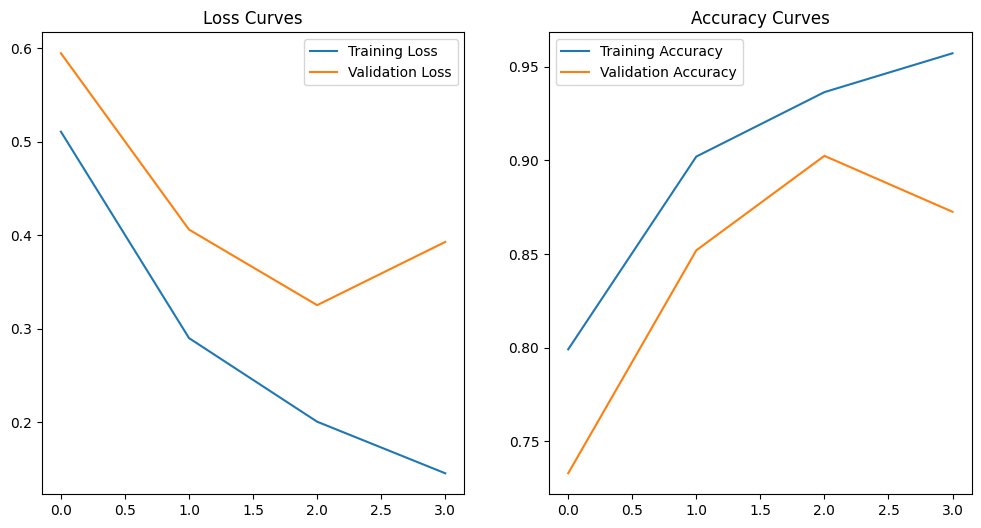

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertModel, BertConfig
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Load and Clean the Dataset
df = pd.read_csv('labeled_data.csv')

# Display basic information about the dataset
print("Initial Dataset Information:")
print(df.info())
print(df.head())

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'count']  # Drop these columns if they are irrelevant
df = df.drop(columns=columns_to_drop, errors='ignore')

# Map the labels to a single 'class' column for consistency
df['class'] = df['class'].map({0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'})

# Check for null values
print("\nChecking for null values...")
print(df.isnull().sum())

# Fill or drop missing values (if any)
df.dropna(subset=['tweet', 'class'], inplace=True)

# Display class distribution
print("\nClass Distribution:")
print(df['class'].value_counts())

# Function for text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Display cleaned data
print("\nCleaned Tweets (sample):")
print(df[['tweet', 'clean_tweet']].sample(5))

# Save cleaned data (optional)
df.to_csv('cleaned_data.csv', index=False)

# Split the data into training, validation, and test sets
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

# Handle class imbalance using Random Oversampling
oversampler = RandomOverSampler(random_state=1508)
train_resampled, train_labels_resampled = oversampler.fit_resample(
    train[['clean_tweet']],
    train['class']
)

# Display class distribution after oversampling
print("\nClass Distribution After Oversampling:")
print(pd.Series(train_labels_resampled).value_counts())

# Feature Engineering: Add additional features
def add_features(df):
    df['tweet_length'] = df['clean_tweet'].apply(len)
    df['num_hashtags'] = df['clean_tweet'].apply(lambda x: x.count('#'))
    df['num_mentions'] = df['clean_tweet'].apply(lambda x: x.count('@'))
    df['num_punctuations'] = df['clean_tweet'].apply(lambda x: sum([1 for char in x if char in '.,!?;:']))
    return df

train_resampled = add_features(train_resampled)
validation = add_features(validation)

# Normalize the engineered features
scaler = StandardScaler()
engineered_features = ['tweet_length', 'num_hashtags', 'num_mentions', 'num_punctuations']

# Normalize training features
train_features = scaler.fit_transform(train_resampled[engineered_features])
train_features = torch.tensor(train_features, dtype=torch.float32)

# Normalize validation features
validation_features = scaler.transform(validation[engineered_features])
validation_features = torch.tensor(validation_features, dtype=torch.float32)

# Tokenization
print('Loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encode and prepare for BERT
def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for sentence in data:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 64

train_inputs, train_masks = bert_encode(train_resampled['clean_tweet'], MAX_LEN)
train_labels = pd.factorize(train_labels_resampled)[0]  # Convert labels to numeric

validation_inputs, validation_masks = bert_encode(validation['clean_tweet'], MAX_LEN)
validation_labels = pd.factorize(validation['class'])[0]

train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
validation_labels = torch.tensor(validation_labels)

# Dataloader preparation
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_features)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_features)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Define flat_accuracy function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define BERT + LSTM Model with Features
class BertLSTMClassifierWithFeatures(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_labels=3, hidden_dim=256, num_features=4):
        super(BertLSTMClassifierWithFeatures, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_dim, batch_first=True)
        self.feature_layer = nn.Linear(num_features, hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask, additional_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state
        lstm_output, (h_n, _) = self.lstm(last_hidden_state)
        feature_output = self.feature_layer(additional_features)
        combined = torch.cat((h_n[-1], feature_output), dim=1)
        logits = self.classifier(combined)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertLSTMClassifierWithFeatures().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Choose learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  # Cosine Annealing
# Alternatively, use cyclical learning rates
# scheduler = CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=2000, mode='triangular')

epochs = 4
accumulation_steps = 4  # Simulating larger batch size
scaler = GradScaler()

# Early Stopping parameters
early_stopping_patience = 2
best_val_loss = float('inf')
patience_counter = 0

# Lists for metrics
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

# Training loop
for epoch_i in range(epochs):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_features = batch[3].to(device)

        model.zero_grad()

        with autocast():
            logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)

        total_loss += loss.item()
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:  # Accumulate gradients
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
        total_preds += len(b_labels)

    train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_preds / total_preds
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Scheduler step
    scheduler.step()

    # Validation step
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)

        loss = nn.CrossEntropyLoss()(logits, b_labels)
        total_loss += loss.item()

        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
        total_preds += len(b_labels)

    avg_val_loss = total_loss / len(validation_dataloader)
    val_accuracy = correct_preds / total_preds
    validation_losses.append(avg_val_loss)
    validation_accuracies.append(val_accuracy)

    print(f"Epoch {epoch_i+1}/{epochs}, Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch_i+1}/{epochs}, Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch_i+1}.")
            break

# Final classification report
model.eval()
preds = []
true_labels = []
for batch in validation_dataloader:
    b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
    preds.extend(np.argmax(logits.detach().cpu().numpy(), axis=1))
    true_labels.extend(b_labels.detach().cpu().numpy())

print("\nClassification Report (Validation Data):")
print(classification_report(true_labels, preds))

# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), validation_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy")
plt.plot(range(epochs), validation_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()


# STEP 4:
1. Layer Freezing:Fine-tune only the top layers of BERT initially (freeze lower layers):

2. Dropout Regularization:Add dropout layers after the LSTM and fully connected layers:

3. Multi-Head Attention:Integrate a multi-head attention mechanism after the LSTM to capture relationships more effectively.

4. Hierarchical Attention:Use a hierarchical attention network (HAN) to focus on more informative words and sentences.

5. L2 regularization (weight decay)

Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4          

<ipython-input-17-1b61ca48337a>:212: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-1b61ca48337a>:234: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss = 1.0980, Train Accuracy = 0.3526
Epoch 1: Val Loss = 1.1070, Val Accuracy = 0.3977
Epoch 2: Train Loss = 1.0976, Train Accuracy = 0.3573
Epoch 2: Val Loss = 1.0911, Val Accuracy = 0.5228
Epoch 3: Train Loss = 1.0971, Train Accuracy = 0.3555
Epoch 3: Val Loss = 1.0883, Val Accuracy = 0.5276
Epoch 4: Train Loss = 1.0971, Train Accuracy = 0.3574
Epoch 4: Val Loss = 1.0999, Val Accuracy = 0.4582


<ipython-input-17-1b61ca48337a>:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.56      0.66      1902
           1       0.21      0.57      0.31       435
           2       0.00      0.00      0.00       142

    accuracy                           0.53      2479
   macro avg       0.34      0.37      0.32      2479
weighted avg       0.65      0.53      0.56      2479



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


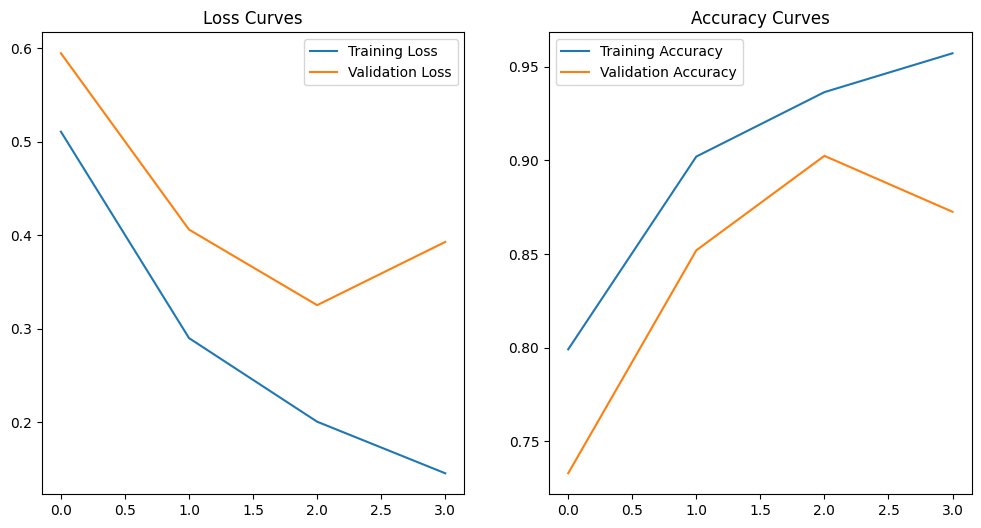

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
from torch.cuda.amp import autocast, GradScaler
# from transformers import get_cosine_schedule_with_warmup, CyclicLR
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Load and Clean the Dataset
df = pd.read_csv('labeled_data.csv')

# Display basic information about the dataset
print("Initial Dataset Information:")
print(df.info())
print(df.head())

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'count']  # Drop these columns if they are irrelevant
df = df.drop(columns=columns_to_drop, errors='ignore')

# Map the labels to a single 'class' column for consistency
df['class'] = df['class'].map({0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'})

# Check for null values
print("\nChecking for null values...")
print(df.isnull().sum())

# Fill or drop missing values (if any)
df.dropna(subset=['tweet', 'class'], inplace=True)

# Display class distribution
print("\nClass Distribution:")
print(df['class'].value_counts())

# Function for text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply text cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# Display cleaned data
print("\nCleaned Tweets (sample):")
print(df[['tweet', 'clean_tweet']].sample(5))

# Save cleaned data (optional)
df.to_csv('cleaned_data.csv', index=False)

# Split the data into training, validation, and test sets
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

# Handle class imbalance using Random Oversampling
oversampler = RandomOverSampler(random_state=1508)
train_resampled, train_labels_resampled = oversampler.fit_resample(
    train[['clean_tweet']],
    train['class']
)

# Display class distribution after oversampling
print("\nClass Distribution After Oversampling:")
print(pd.Series(train_labels_resampled).value_counts())

# Feature Engineering: Add additional features
def add_features(df):
    df['tweet_length'] = df['clean_tweet'].apply(len)
    df['num_hashtags'] = df['clean_tweet'].apply(lambda x: x.count('#'))
    df['num_mentions'] = df['clean_tweet'].apply(lambda x: x.count('@'))
    df['num_punctuations'] = df['clean_tweet'].apply(lambda x: sum([1 for char in x if char in '.,!?;:']))
    return df

train_resampled = add_features(train_resampled)
validation = add_features(validation)

# Normalize the engineered features
scaler = StandardScaler()
engineered_features = ['tweet_length', 'num_hashtags', 'num_mentions', 'num_punctuations']

# Normalize training features
train_features = scaler.fit_transform(train_resampled[engineered_features])
train_features = torch.tensor(train_features, dtype=torch.float32)

# Normalize validation features
validation_features = scaler.transform(validation[engineered_features])
validation_features = torch.tensor(validation_features, dtype=torch.float32)

# Tokenization
print('Loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encode and prepare for BERT
def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for sentence in data:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 64

train_inputs, train_masks = bert_encode(train_resampled['clean_tweet'], MAX_LEN)
train_labels = pd.factorize(train_labels_resampled)[0]  # Convert labels to numeric

validation_inputs, validation_masks = bert_encode(validation['clean_tweet'], MAX_LEN)
validation_labels = pd.factorize(validation['class'])[0]

train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
validation_labels = torch.tensor(validation_labels)

# Dataloader preparation
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_features)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_features)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Define flat_accuracy function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Define BERT + LSTM Model with Features and Multi-Head Attention + Dropout + Layer Freezing
class BertLSTMClassifierWithAttention(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_labels=3, hidden_dim=256, num_features=4):
        super(BertLSTMClassifierWithAttention, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Freeze all layers except the top few (e.g., freeze first 8 layers)
        for name, param in self.bert.named_parameters():
            # Freeze layers in a more robust way by checking if the layer is part of BERT's encoder
            if 'encoder.layer' in name and int(name.split('.')[2]) < 8:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_dim, batch_first=True)

        # Multi-Head Attention Layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.1)

        # Fully Connected Layer
        self.feature_layer = nn.Linear(num_features, hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask, additional_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state
        lstm_output, (h_n, _) = self.lstm(last_hidden_state)

        # Multi-Head Attention on LSTM output
        attn_output, _ = self.multihead_attention(lstm_output, lstm_output, lstm_output)

        # Combine with additional features
        feature_output = self.feature_layer(additional_features)
        combined = torch.cat((attn_output[:, -1, :], feature_output), dim=1)

        # Dropout and Final Classifier
        combined = self.dropout(combined)
        logits = self.classifier(combined)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertLSTMClassifierWithAttention().to(device)
# Define optimizer with weight decay (L2 regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)


epochs = 4
total_steps = len(train_dataloader) * epochs

# Choose scheduler: CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)  # Cosine Annealing

scaler = GradScaler()

# Early stopping setup
best_val_loss = float('inf')
patience = 3  # Early stopping patience
patience_counter = 0

# Training loop
for epoch_i in range(epochs):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_features = batch[3].to(device)

        optimizer.zero_grad()

        with autocast():
            logits = model(b_input_ids, b_input_mask, b_features)
            # Check for NaN/Inf in logits before computing loss
            if torch.isnan(logits).any() or torch.isinf(logits).any():
              print(f"NaN or Inf found in logits at step {step}")
              continue  # Skip this batch

            loss = nn.CrossEntropyLoss()(logits, b_labels)

             # Check if loss is NaN
            if torch.isnan(loss).any():
                print(f"NaN found in loss at step {step}")
                continue  # Skip this batch

        scaler.scale(loss).backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        correct_preds += (preds == b_labels.cpu().numpy()).sum()
        total_preds += b_labels.size(0)

        # Gradient Accumulation
        if (step + 1) % 2 == 0:  # Accumulate every 2 steps
            optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_preds / total_preds
    print(f"Epoch {epoch_i+1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            b_features = batch[3].to(device)

            logits = model(b_input_ids, b_input_mask, b_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)

            total_val_loss += loss.item()
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            val_correct_preds += (preds == b_labels.cpu().numpy()).sum()
            val_total_preds += b_labels.size(0)

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = val_correct_preds / val_total_preds
    print(f"Epoch {epoch_i+1}: Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    scheduler.step()

# Evaluate the model & print the Final classification report
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

predictions, true_labels = [], []
with torch.no_grad():
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_features = batch[3].to(device)

        logits = model(b_input_ids, b_input_mask, b_features)
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)

        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

print("Classification Report:")
print(classification_report(true_labels, predictions))

# Save the trained model
torch.save(model.state_dict(), "final_model.pth")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), validation_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy")
plt.plot(range(epochs), validation_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


# STEP 3 + OPTUNA

Best hyperparameters after applying OPTUNA: {'hidden_dim': 512, 'lr': 4.249470853164469e-06, 'batch_size': 32}


<ipython-input-6-dbbbf21b82de>:238: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-dbbbf21b82de>:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/4, Train Loss: 0.71, Train Accuracy: 0.6970
Epoch 1/4, Validation Loss: 0.54, Validation Accuracy: 0.7773
Epoch 2/4, Train Loss: 0.39, Train Accuracy: 0.8629
Epoch 2/4, Validation Loss: 0.50, Validation Accuracy: 0.7870
Epoch 3/4, Train Loss: 0.32, Train Accuracy: 0.8903
Epoch 3/4, Validation Loss: 0.42, Validation Accuracy: 0.8395
Epoch 4/4, Train Loss: 0.27, Train Accuracy: 0.9116
Epoch 4/4, Validation Loss: 0.42, Validation Accuracy: 0.8507

Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1902
           1       0.86      0.92      0.89       435
           2       0.25      0.58      0.35       142

    accuracy                           0.85      2479
   macro avg       0.69      0.78      0.72      2479
weighted avg       0.90      0.85      0.87      2479



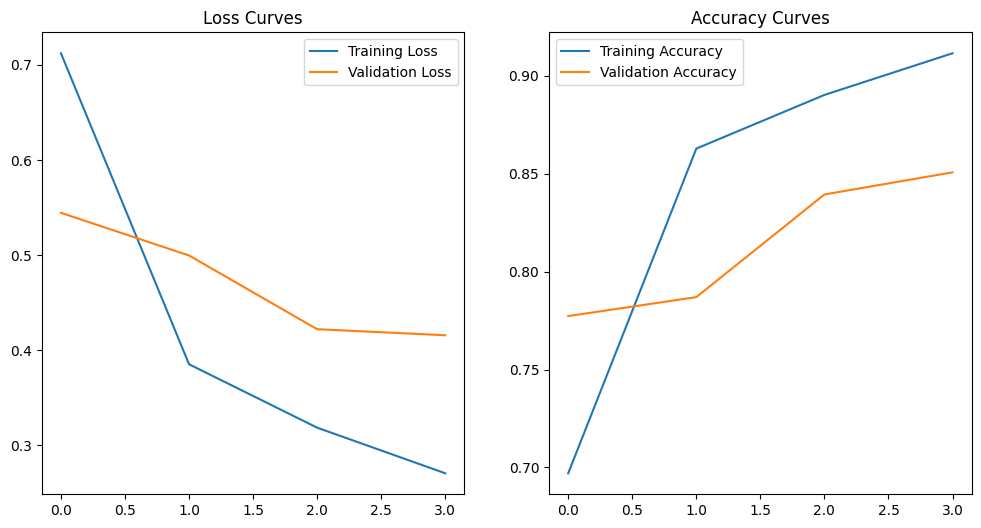

In [ ]:
import numpy as np
import pandas as pd
import torch
import re
import optuna
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Step 1: Load and Clean the Dataset
df = pd.read_csv('labeled_data.csv')

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'count']
df = df.drop(columns=columns_to_drop, errors='ignore')
df['class'] = df['class'].map({0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'})
df.dropna(subset=['tweet', 'class'], inplace=True)

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_tweet'] = df['tweet'].apply(clean_text)

# Split the dataset into train, validation, and test sets
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

# Oversampling to handle class imbalance
oversampler = RandomOverSampler(random_state=1508)
train_resampled, train_labels_resampled = oversampler.fit_resample(
    train[['clean_tweet']],
    train['class']
)

# Feature engineering (e.g., tweet length, number of hashtags)
def add_features(df):
    df['tweet_length'] = df['clean_tweet'].apply(len)
    df['num_hashtags'] = df['clean_tweet'].apply(lambda x: x.count('#'))
    df['num_mentions'] = df['clean_tweet'].apply(lambda x: x.count('@'))
    df['num_punctuations'] = df['clean_tweet'].apply(lambda x: sum([1 for char in x if char in '.,!?;:']))
    return df

train_resampled = add_features(train_resampled)
validation = add_features(validation)

# Normalize features
scaler = StandardScaler()
engineered_features = ['tweet_length', 'num_hashtags', 'num_mentions', 'num_punctuations']
train_features = scaler.fit_transform(train_resampled[engineered_features])
validation_features = scaler.transform(validation[engineered_features])

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encoding function
def bert_encode(data, max_len):
    input_ids, attention_masks = [], []
    for sentence in data:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 64
train_inputs, train_masks = bert_encode(train_resampled['clean_tweet'], MAX_LEN)
train_labels = pd.factorize(train_labels_resampled)[0]
validation_inputs, validation_masks = bert_encode(validation['clean_tweet'], MAX_LEN)
validation_labels = pd.factorize(validation['class'])[0]

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)
validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
validation_labels = torch.tensor(validation_labels)

# Dataloader preparation
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels, torch.tensor(train_features, dtype=torch.float32))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, torch.tensor(validation_features, dtype=torch.float32))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Define the BERT + LSTM model
class BertLSTMClassifierWithFeatures(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_labels=3, hidden_dim=None, num_features=4):
        super(BertLSTMClassifierWithFeatures, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_dim, batch_first=True)
        self.feature_layer = nn.Linear(num_features, hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask, additional_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state
        lstm_output, (h_n, _) = self.lstm(last_hidden_state)
        feature_output = self.feature_layer(additional_features)
        combined = torch.cat((h_n[-1], feature_output), dim=1)
        logits = self.classifier(combined)
        return logits


# ============================================================================ OPTUNA ==============================================================================

# # Optuna objective function is commented out after we got the Best parameters as {'hidden_dim': 512, 'lr': 4.249470853164469e-06, 'batch_size': 32}

# def objective(trial):
#     # Hyperparameter search space
#     hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=128)
#     lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

#     # Model and optimizer setup
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = BertLSTMClassifierWithFeatures(hidden_dim=hidden_dim).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#     scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

#     # Training loop
#     epochs = 4
#     scaler = GradScaler()

#     for epoch_i in range(epochs):
#         model.train()
#         total_loss = 0
#         correct_preds = 0
#         total_preds = 0
#         for step, batch in enumerate(train_dataloader):
#             b_input_ids = batch[0].to(device)
#             b_input_mask = batch[1].to(device)
#             b_labels = batch[2].to(device)
#             b_features = batch[3].to(device)

#             model.zero_grad()
#             with autocast():
#                 logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
#                 loss = nn.CrossEntropyLoss()(logits, b_labels)

#             total_loss += loss.item()
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()

#             preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
#             correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
#             total_preds += len(b_labels)

#         avg_train_loss = total_loss / len(train_dataloader)
#         train_accuracy = correct_preds / total_preds

#         # Validation step
#         model.eval()
#         total_loss = 0
#         correct_preds = 0
#         total_preds = 0
#         for batch in validation_dataloader:
#             b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)

#             with torch.no_grad():
#                 logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)

#             loss = nn.CrossEntropyLoss()(logits, b_labels)
#             total_loss += loss.item()

#             preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
#             correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
#             total_preds += len(b_labels)

#         avg_val_loss = total_loss / len(validation_dataloader)
#         val_accuracy = correct_preds / total_preds

#     return avg_val_loss  # Optuna will minimize this value

# # Run Optuna optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)

# # Print the best hyperparameters
# print("Best hyperparameters:", study.best_params)

# =========================================================================== END ==============================================================================

print("Best hyperparameters after applying OPTUNA: {'hidden_dim': 512, 'lr': 4.249470853164469e-06, 'batch_size': 32}")

# Define a variable to store the best parameters
best_params = {'hidden_dim': 512, 'lr': 4.249470853164469e-06, 'batch_size': 32}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Extract hyperparameters
best_hidden_dim = best_params['hidden_dim']
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']

# Step 2: Recreate and train the model using the best hyperparameters

# Recreate the model with the best hidden dimension
model = BertLSTMClassifierWithFeatures(hidden_dim=best_hidden_dim).to(device)

# Optimizer setup with the best learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr)

# Set up a learning rate scheduler (optional but often helpful)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Recreate the DataLoader using the best batch size
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=best_batch_size
)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=best_batch_size
)

epochs = 4
accumulation_steps = 4  # Simulating larger batch size
scaler = GradScaler()

# Early Stopping parameters
early_stopping_patience = 2
best_val_loss = float('inf')
patience_counter = 0

# Lists for metrics
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

# Training loop
for epoch_i in range(epochs):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_features = batch[3].to(device)

        model.zero_grad()

        with autocast():
            logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
            loss = nn.CrossEntropyLoss()(logits, b_labels)

        total_loss += loss.item()
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:  # Accumulate gradients
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
        total_preds += len(b_labels)

    train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_preds / total_preds
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Scheduler step
    scheduler.step()

    # Validation step
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)

        loss = nn.CrossEntropyLoss()(logits, b_labels)
        total_loss += loss.item()

        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        correct_preds += np.sum(preds == b_labels.detach().cpu().numpy())
        total_preds += len(b_labels)

    avg_val_loss = total_loss / len(validation_dataloader)
    val_accuracy = correct_preds / total_preds
    validation_losses.append(avg_val_loss)
    validation_accuracies.append(val_accuracy)

    print(f"Epoch {epoch_i+1}/{epochs}, Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Epoch {epoch_i+1}/{epochs}, Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch_i+1}.")
            break

# Final classification report
model.eval()
preds = []
true_labels = []
for batch in validation_dataloader:
    b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
    preds.extend(np.argmax(logits.detach().cpu().numpy(), axis=1))
    true_labels.extend(b_labels.detach().cpu().numpy())

print("\nClassification Report (Validation Data):")
print(classification_report(true_labels, preds))

# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), validation_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy")
plt.plot(range(epochs), validation_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()


# STEP 5 (FROM STEP 3 + OPTUNA ONWARDS)
1. Macro F1 Optimization:
Modify the training process to optimize for the macro F1 score by implementing:
A custom loss function that emphasizes performance across all classes equally.
Adjusting thresholds for better balance.
We'll replace CrossEntropyLoss with a macro F1 loss implementation.

2. Error Analysis:
Analyze the validation set's misclassifications, identify patterns, and handle frequent errors with:
Data augmentation AND Adding specific rules for edge cases.
3. Output Smoothing
Implement label smoothing to prevent the model from being overly confident in predictions, which helps to generalize better.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10
  Train Loss: 0.2101 | Train Accuracy: 0.8205
  Validation Loss: 0.3398 | Validation Accuracy: 0.7854 | Macro F1: 0.6773
Epoch 2/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1648 | Train Accuracy: 0.8463
  Validation Loss: 0.3173 | Validation Accuracy: 0.8415 | Macro F1: 0.7036
Epoch 3/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1540 | Train Accuracy: 0.8539
  Validation Loss: 0.3258 | Validation Accuracy: 0.7939 | Macro F1: 0.6878
Epoch 4/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1448 | Train Accuracy: 0.8628
  Validation Loss: 0.3149 | Validation Accuracy: 0.8314 | Macro F1: 0.7026
Epoch 5/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1406 | Train Accuracy: 0.8671
  Validation Loss: 0.3018 | Validation Accuracy: 0.8544 | Macro F1: 0.7188
Epoch 6/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1317 | Train Accuracy: 0.8751
  Validation Loss: 0.3191 | Validation Accuracy: 0.8265 | Macro F1: 0.6975
Epoch 7/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1233 | Train Accuracy: 0.8826
  Validation Loss: 0.3123 | Validation Accuracy: 0.8540 | Macro F1: 0.7117
Epoch 8/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1190 | Train Accuracy: 0.8866
  Validation Loss: 0.3007 | Validation Accuracy: 0.8588 | Macro F1: 0.7211
Epoch 9/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1153 | Train Accuracy: 0.8906
  Validation Loss: 0.2949 | Validation Accuracy: 0.8673 | Macro F1: 0.7293
Epoch 10/10


<ipython-input-7-17772ba704c6>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Train Loss: 0.1128 | Train Accuracy: 0.8929
  Validation Loss: 0.2974 | Validation Accuracy: 0.8645 | Macro F1: 0.7261

Error Analysis:
Tweet: you gotta be a new breed of retarded if you do that
True: 0
Predicted: 2

Tweet: meshanojas vontethekidd 128079128079128079128079128588 i got hicks lol
True: 1
Predicted: 0

Tweet: rt juliarodd when kennies angry he talks like a ghetto black man and i really dont even think he notices hahahahahahaha im laughing 8230
True: 2
Predicted: 1

Tweet: buckm00se darealalexinla i didnt spoil anything amp you should have been watched it nigger nig nog
True: 0
Predicted: 2

Tweet: fuck that niggah he so weak he cant tell that you a freak
True: 2
Predicted: 0

Tweet: brocktonbitch we niggas like fuckin roaches let one in and you hot dam infested you a crazy bitch i dig yo ass
True: 0
Predicted: 2

Tweet: get out granny longjohns rednecksfor your cold bones from very cold polar vortex the sequel dog
True: 0
Predicted: 1

Tweet: niggas retarded lol
True: 0


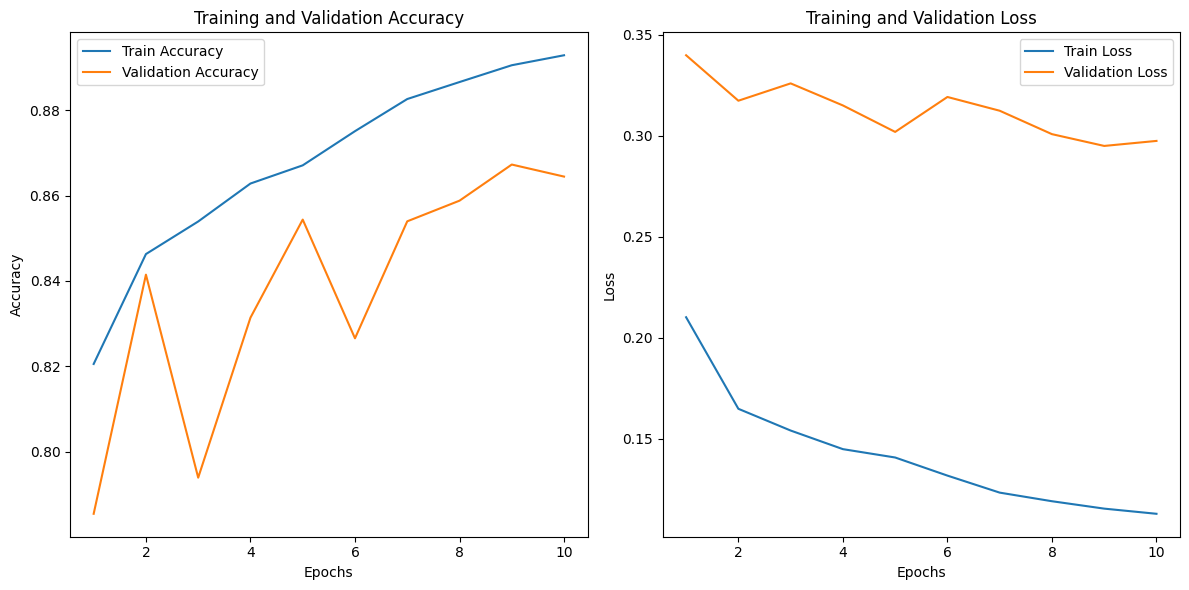

In [ ]:
import numpy as np
import pandas as pd
import torch
import re
import optuna
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('labeled_data.csv')

columns_to_drop = ['Unnamed: 0', 'count']
df = df.drop(columns=columns_to_drop, errors='ignore')
df['class'] = df['class'].map({0: 'Hate Speech', 1: 'Offensive', 2: 'Neutral'})
df.dropna(subset=['tweet', 'class'], inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_tweet'] = df['tweet'].apply(clean_text)

train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

oversampler = RandomOverSampler(random_state=1508)
train_resampled, train_labels_resampled = oversampler.fit_resample(
    train[['clean_tweet']],
    train['class']
)

# Add features
def add_features(df):
    df['tweet_length'] = df['clean_tweet'].apply(len)
    df['num_hashtags'] = df['clean_tweet'].apply(lambda x: x.count('#'))
    df['num_mentions'] = df['clean_tweet'].apply(lambda x: x.count('@'))
    df['num_punctuations'] = df['clean_tweet'].apply(lambda x: sum([1 for char in x if char in '.,!?;:']))
    return df

train_resampled = add_features(train_resampled)
validation = add_features(validation)

# Normalize features
scaler = StandardScaler()
engineered_features = ['tweet_length', 'num_hashtags', 'num_mentions', 'num_punctuations']
train_features = scaler.fit_transform(train_resampled[engineered_features])
validation_features = scaler.transform(validation[engineered_features])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(data, max_len):
    input_ids, attention_masks = [], []
    for sentence in data:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 64
train_inputs, train_masks = bert_encode(train_resampled['clean_tweet'], MAX_LEN)
train_labels = pd.factorize(train_labels_resampled)[0]
validation_inputs, validation_masks = bert_encode(validation['clean_tweet'], MAX_LEN)
validation_labels = pd.factorize(validation['class'])[0]

# PyTorch tensors
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)
validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(validation_masks)
validation_labels = torch.tensor(validation_labels)

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels, torch.tensor(train_features, dtype=torch.float32))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, torch.tensor(validation_features, dtype=torch.float32))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Define the model
class BertLSTMClassifierWithFeatures(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", num_labels=3, hidden_dim=None, num_features=4):
        super(BertLSTMClassifierWithFeatures, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, hidden_size=hidden_dim, batch_first=True, dropout=0.3)
        self.feature_layer = nn.Linear(num_features, hidden_dim)
        self.dropout = nn.Dropout(0.3)  # Add Dropout Layer
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask, additional_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state
        lstm_output, (h_n, _) = self.lstm(last_hidden_state)
        feature_output = self.feature_layer(additional_features)
        combined = torch.cat((h_n[-1], feature_output), dim=1)
        combined = self.dropout(combined)  # Apply dropout
        logits = self.classifier(combined)
        return logits


# Custom Losses
class MacroF1Loss(nn.Module):
    def __init__(self, num_classes, epsilon=1e-7):
        super(MacroF1Loss, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon

    def forward(self, logits, labels):
        # Ensure logits and labels are float tensors
        probs = torch.softmax(logits, dim=1)
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=self.num_classes).float()

        tp = torch.sum(labels_one_hot * probs, dim=0)
        fp = torch.sum((1 - labels_one_hot) * probs, dim=0)
        fn = torch.sum(labels_one_hot * (1 - probs), dim=0)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)

        # Mean Macro F1
        macro_f1 = f1.mean()
        return 1 - macro_f1  # Minimize 1 - F1 for maximization


class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, logits, labels):
        num_classes = logits.size(1)
        smoothed_labels = torch.full(size=(labels.size(0), num_classes), fill_value=self.smoothing / (num_classes - 1))
        smoothed_labels.scatter_(1, labels.unsqueeze(1), 1 - self.smoothing)
        log_probs = nn.functional.log_softmax(logits, dim=1)
        loss = -torch.sum(smoothed_labels * log_probs) / labels.size(0)
        return loss

# Error Analysis
def analyze_errors(true_labels, predictions, data):
    errors = [(data.iloc[i]['clean_tweet'], true, pred)
              for i, (true, pred) in enumerate(zip(true_labels, predictions)) if true != pred]
    for tweet, true, pred in errors[:10]:  # Display the first 10 misclassified examples
        print(f"Tweet: {tweet}\nTrue: {true}\nPredicted: {pred}\n")


# Training Hyperparameters
epochs = 10
learning_rate = 2e-5
early_stopping_patience = 3
best_val_loss = float('inf')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model, Optimizer, Scheduler
model = BertLSTMClassifierWithFeatures(hidden_dim=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scaler = torch.amp.GradScaler(enabled=True)  # Ensure it's explicitly enabled
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Loss functions
macro_f1_loss = MacroF1Loss(num_classes=3)
label_smoothing_loss = LabelSmoothingLoss(smoothing=0.1)

# Metrics storage
train_losses, validation_losses = [], []
train_accuracies, validation_accuracies = [], []


# Training Loop
for epoch_i in range(epochs):
    print(f"Epoch {epoch_i + 1}/{epochs}")

    # Training Phase
    model.train()
    total_loss, correct_preds, total_preds = 0, 0, 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_features = batch[3].to(device)

        # print(f"Input IDs requires_grad: {b_input_ids.requires_grad}")
        # print(f"Features requires_grad: {b_features.requires_grad}")


        model.zero_grad()

        with autocast():
          logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
          loss = macro_f1_loss(logits, b_labels)  # Macro F1 Loss

        # print(f"Loss requires_grad: {loss.requires_grad}")  # Should be True


        total_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = torch.argmax(logits.detach(), dim=1)
        correct_preds += (preds == b_labels).sum().item()
        total_preds += b_labels.size(0)

    train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_preds / total_preds
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")

    # Scheduler Step
    scheduler.step()

    # Validation Phase
    model.eval()
    total_loss, correct_preds, total_preds = 0, 0, 0
    all_preds, all_labels = [], []

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels, b_features = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, additional_features=b_features)
            loss = macro_f1_loss(logits, b_labels)  # Validation uses Macro F1 Loss
            total_loss += loss.item()

            preds = torch.argmax(logits.detach(), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())
            correct_preds += (preds == b_labels).sum().item()
            total_preds += b_labels.size(0)

    avg_val_loss = total_loss / len(validation_dataloader)
    val_accuracy = correct_preds / total_preds
    validation_losses.append(avg_val_loss)
    validation_accuracies.append(val_accuracy)

    # Calculate Macro F1 Score
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"  Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Macro F1: {macro_f1:.4f}")

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch_i + 1}.")
            break

# Error Analysis
print("\nError Analysis:")
analyze_errors(all_labels, all_preds, validation)

# Classification Report
print("\nFinal Classification Report:")
print(classification_report(all_labels, all_preds))

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

